In [1]:
import warnings;
warnings.filterwarnings('ignore')

In [2]:
import pickle
with open('../data/clean-data-nostem.pkl','rb') as fp:
    X,Y = pickle.load(fp)
fp.close()

In [ ]:
with open('../data/saved-res.pkl','rb') as fp:
    save_res = pickle.load(fp)
fp.close()

In [3]:
l = int(0.8*len(X))

### Class for Tfidf weighted W2V

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import numpy as np

In [5]:
# Code taken from [http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/]
# This uses tfidf weighted w2v
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

### Tokenizing

In [6]:
X = [i.split() for i in X]

### W2V without stemming
Since it gave a better result than stemmed data

In [7]:
import gensim
# let X be a list of tokenized texts (i.e. list of lists of tokens)
model = gensim.models.Word2Vec(X, size=500)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [8]:
vectorizer = TfidfEmbeddingVectorizer(w2v)

In [9]:
vectorizer.fit(X[:l],Y[:l])

In [10]:
tfidf_w2v_tr = vectorizer.transform(X[:l])

In [11]:
tfidf_w2v_ts = vectorizer.transform(X[l:])

In [12]:
pred = {}

### Logistic Regression (L1)

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
lr = LogisticRegression(penalty='l1',C=1e5,class_weight='balanced',n_jobs=-1)

In [15]:
lr.fit(tfidf_w2v_tr,Y[:l])

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [16]:
pred['tdidf w2v LR L1'] = lr.predict(tfidf_w2v_ts)

In [ ]:
save_res['tfidf weighted w2v LR L1'] = pred['tdidf w2v LR L1']

### Logistic Regression (L2)

In [17]:
lr = LogisticRegression(penalty='l2',C=1e5,class_weight='balanced',n_jobs=-1)

In [18]:
lr.fit(tfidf_w2v_tr,Y[:l])

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [19]:
pred['tdidf w2v LR L2'] = lr.predict(tfidf_w2v_ts)

In [ ]:
save_res['tfidf weighted w2v LR L2'] = pred['tdidf w2v LR L2']

### Plotting ROC curve

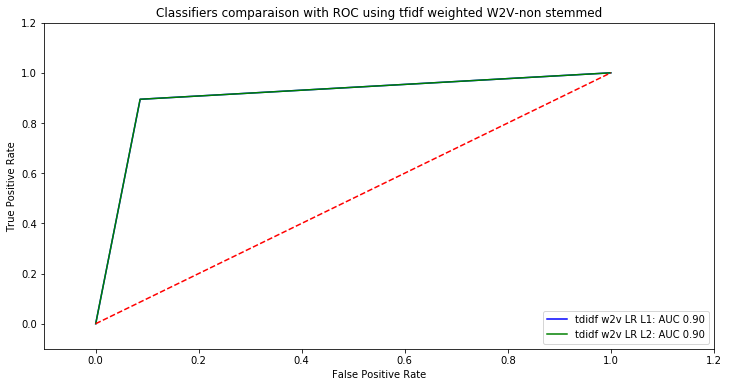

In [20]:
import numpy as np
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))

def formatt(x):
    return x;

vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']

for model, predicted in pred.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y[l:], vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC using tfidf weighted W2V-non stemmed')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Observation without class weights:
* Used vector size as 100, got AUC of 0.80 for both LR
* Used vector size as 200, got AUC of 0.83 for both LR
* Used vector size as 300, got AUC of 0.84 for both LR
* Used vector size as 1000, got AUC of 0.86 for both LR

### Observation with class weights:
* Vector size was kept at 500.
* Got AUC for both L1 and L2 reg as 0.90.


In [ ]:
save_res.keys()

In [ ]:
with open('../data/saved-res.pkl','wb') as fp:
    pickle.dump(save_res,fp)
fp.close()